<a href="https://colab.research.google.com/github/stryduh/Hiragana-Classification/blob/main/Pytorch_Hiragana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
hiragana = np.load("/content/gdrive/MyDrive/hiragana.npz")["arr_0"].reshape([-1, 127, 128])

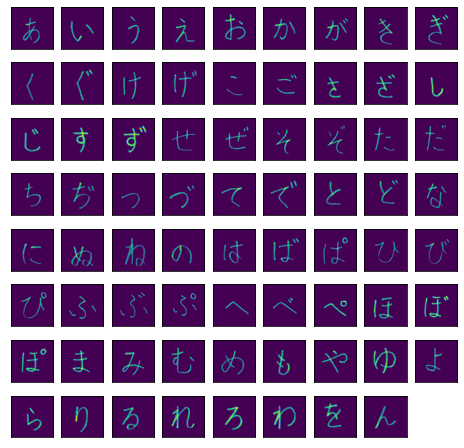

In [ ]:
fig = plt.figure(figsize = (8, 8))
for i in range(71):
  ax = fig.add_subplot(8, 9, i+1, xticks = [], yticks = [])
  ax.imshow(hiragana[160*i])


In [ ]:
class HiraganaDataSet(Dataset):
  def __init__(self, X, Y, transform = None):
    self.data = X
    self.target = Y
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.target[index]

    if self.transform:
      x = self.transform(x)
    return (x, y)

  def __len__(self):
    return len(self.data)

#Random Split
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean = [0.5, ],
                                                     std = [0.5, ]),
                                transforms.Resize(size = (36, 36))]
              )
label = np.arange(71)
labels = np.repeat(label, 160)

hirds = HiraganaDataSet(hiragana, labels, transform = transform)
trainset, valset = torch.utils.data.random_split(hirds, [9088, 2272])

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
valloader = torch.utils.data.DataLoader(valset, batch_size = 64, shuffle = True)

In [ ]:
#Split amongst all categories
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(size = (36, 36))])

categories = 71

label = np.arange(categories)
labels = np.repeat(label, 160)

train_indices = []
valid_indices = []
for i in range(categories):
  train_indices += list(range(i*160, i*160+130))
  valid_indices += list(range(i*160+130, i*160+160))

print("train_size:", len(train_indices), "valid_size:", len(valid_indices))

hirds_train = HiraganaDataSet(hiragana[train_indices,:,:], labels[train_indices], transform = transform)
hirds_valid = HiraganaDataSet(hiragana[valid_indices,:,:], labels[valid_indices], transform = transform)

trainloader = torch.utils.data.DataLoader(hirds_train, batch_size = 32, shuffle = True)
testloader = torch.utils.data.DataLoader(hirds_valid, batch_size = 32, shuffle = True)

train_size: 9230 valid_size: 2130


In [ ]:
hirds_train[0][0].size()

torch.Size([1, 36, 36])

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # input is 36*36
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size = 5, stride = 1),#32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)#16
        ) #output is 16
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 24, kernel_size = 5, stride = 1), #12
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) #6
        ) 
        self.layer3 = nn.Sequential(
            nn.Conv2d(24, 48, kernel_size = 5, stride = 1), # output is 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) #1
        ) 

        self.drop_out = nn.Dropout(0.5)
        self.fc1 = nn.Linear(6 * 6 * 24, 256)
        self.fc2 = nn.Linear(256, 71)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #out = self.layer3(out)

        out = out.view(-1, 6 * 6 * 24)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

# create a net based on your architecture
model = ConvNet()

# move the model to GPU
# GPU is faster than CPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [ ]:
for epoch in range(200):
    # create a record variable for loss per epoch
    train_loss = 0

    # each time we load a mini-batch (64 sample points) of data and perform the update
    for data, labels in trainloader:

        # move the input and label to GPU memory where GPU can access
        data, labels = data.to(device), labels.to(device)

        # feed the mini-batch data to the network and get the output
        output = model(data)

        # compute the error using the loss function
        loss = loss_function(output, labels)

        # clear the gradient before we compute it
        optimizer.zero_grad()
        # compute the gradient using back-propagation
        loss.backward()
        # update the parameter
        optimizer.step()

        # sum up the error for current 64 data points
        train_loss += loss.item()*data.size(0)
        
    # compute the average error for the whole training set
    train_loss = train_loss/len(trainloader.dataset)

    # print it so you can monitor it
    if not epoch % 25:
      print('Epoch-{} Training Loss: {:.4f}'.format(epoch+1, train_loss))

Epoch-1 Training Loss: 0.4354
Epoch-26 Training Loss: 0.3087
Epoch-51 Training Loss: 0.2202
Epoch-76 Training Loss: 0.1537
Epoch-101 Training Loss: 0.1041
Epoch-126 Training Loss: 0.0685
Epoch-151 Training Loss: 0.0452
Epoch-176 Training Loss: 0.0283


In [ ]:
# track the accuracy (correct ratio)
total_correct = 0

# similar to training, we load the mini-batch to feed to the network iteratively
for data, labels in testloader:
    #print(min(labels))
    # move inputs and labels to GPU
    data, labels = data.to(device), labels.to(device)
    # feed the input to network and get the output
    output = model(data)

    # get the prediction category by finding the max value index
    _, predicted = torch.max(output, 1)
    #print(predicted, labels)
    #print(output)
    # count the correct prediction number for this mini-batch
    total_correct += (predicted == labels).sum().item()


# print the accuracy (correct prediction rate) 
print('\nTest Accuracy: {:.2f}% ({:d}/{:d})'.format(
    100. * total_correct / len(testloader.dataset), total_correct, len(testloader.dataset)))


Test Accuracy: 86.71% (1847/2130)


In [ ]:
model_save_name = 'hiragana_model.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}" 
torch.save(model.state_dict(), path)